<a href="https://colab.research.google.com/github/xenotaur/SocialNavAPI/blob/main/social_nav_api_for_gym_collision_avoidance_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# V2 Prototyping the SocialNavAPI for Gym-Collsion-Avoidance

This is an attempt to get the Social Nav API from the Principles and Guidelines for Social Navigation paper running with Gym-Collision-Avoidance, defined at:   https://github.com/mit-acl/gym-collision-avoidance

## Imports

First, gym-collision-avoidance, which is available via pip.

In [1]:
!pip install gym-collision-avoidance
import gym_collision_avoidance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of moviepy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.0/374.0 kB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.8/398.8 kB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.0/373.0 kB 26.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl siz

Other required imports for gym-collision-avoidance examples or the Social Nav API.

In [2]:
import os
import pprint

import gym
import matplotlib.pyplot as plt
import numpy as np
from shapely import geometry

import tensorflow.compat.v1 as tf


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test code needed for gym-collision-avoidance examples.

In [3]:
gym.logger.set_level(40)
os.environ["GYM_CONFIG_CLASS"] = "Example"
from gym_collision_avoidance.envs import Config
from gym_collision_avoidance.envs import test_cases as tc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Utility Code

In [4]:
def print_divider(length=72, character='-'):
  print(character * length)

def print_message(message, length=72, character='-'):
  print_divider(length=length, character=character)
  print(character, message, character)
  print_divider(length=length, character=character)


def raise_bollard(message="Forcing stop of execution"):
  print_message(message)
  raise RuntimeError(message)


## The Social Nav API

Core Social Nav Wrapper API from the paper.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


------------------------------------------------------------------------
- Example -
------------------------------------------------------------------------
0
10
20
30
40
50
60
70
80
90

------------------------------------------------------------------------
- Info -
------------------------------------------------------------------------
{'collisions': 0,
 'obstacle_data': [],
 'pedestrian_data': [{'goal': array([-3., -3.]),
                      'position': array([-2.864, -2.864]),
                      'velocity': array([0., 0.])}],
 'robot_data': {'goal': array([3., 3.]),
                'position': array([ 7., -3.]),
                'shortest_path': 8.414867794564572,
                'velocity': array([1., 0.])},
 'success': False,
 'timestep': 0.1,
 'which_agents_done': {0: False, 1: True},
 'which_agents_learning': {0: True, 1: False}}

------------------------------------------------------------------------
- Metrics -
---------------------------------------------------------

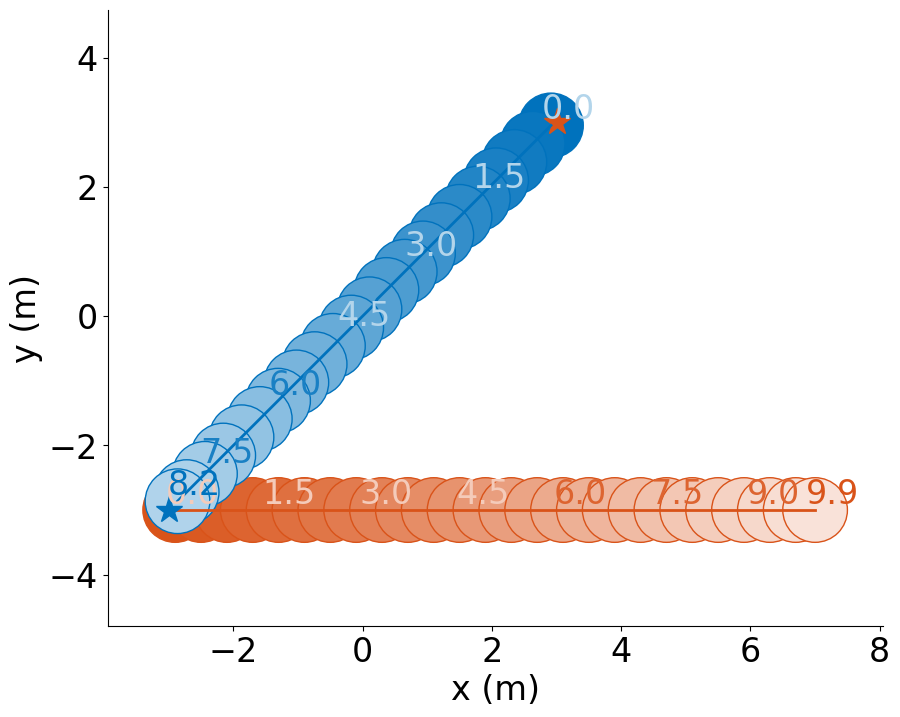

In [20]:
#-----------------------------------------------------
# Core wrapper
#-----------------------------------------------------
class SocialNavWrapper(gym.Wrapper):
    def __init__(self, env, metrics):
      super().__init__(env)
      self.env = env
      self.metrics = [metric(self) for metric in metrics]

      self.time = 0
      self.steps = 0
      self.history = []

    @property
    def state(self):
      return self.history[-1] if self.history else None

    def reset(self):
      self.time = 0
      self.steps = 0
      self.history = []
      return self.env.reset()

    def step(self, action):
      observation, reward, terminated, truncated, info = self.env.step(action)
      self.parse_info(info)
      return observation, reward, terminated, truncated, info

    def parse_info(self, info):
      self.history.append(State.create_from_info(info))
      self.time += self.state.timestep
      self.steps += 1

    def get_metrics(self):
      metric_values = {}
      for metric in self.metrics:
        metric_values.update(metric.compute())
      return metric_values

    def render(self):
        plt.clf()
        for pedestrian in self.pedestrians:
            plt.scatter(pedestrian.position[0], pedestrian.position[1], color="b")
        plt.scatter(self.robot.position[0], self.robot.position[1], color="r")
        for obstacle in self.obstacles:
            x, y = obstacle.poly.exterior.xy
            plt.plot(x, y, color="k")
        plt.show(block=False)
        plt.pause(0.1)


#-----------------------------------------------------
# State and info parsing
#-----------------------------------------------------
class State:
  def __init__(self,
               robot,
               pedestrians,
               obstacles,
               collisions,
               success,
               timestep):
    self.robot = robot
    self.pedestrians = pedestrians
    self.obstacles = obstacles
    self.collisions = collisions
    self.success = success
    self.timestep = timestep

  @property
  def min_distance_to_other_agents(self):
    robot_position = self.robot.position
    return min([
        np.linalg.norm(robot_position - pedestrian.position)
        for pedestrian in self.pedestrians
        ])

  @classmethod
  def create_from_info(cls, info):
    robot = parse_robot(info)
    pedestrians = parse_pedestrians(info)
    obstacles = parse_obstacles(info)
    collisions = parse_collisions(info)
    success = parse_success(info)
    timestep = parse_timestep(info)
    return cls(
        robot=robot,
        pedestrians=pedestrians,
        obstacles=obstacles,
        collisions=collisions,
        success=success,
        timestep=timestep)

def parse_pedestrians(info):
    pedestrian_data = info["pedestrian_data"]
    pedestrians = []
    for data in pedestrian_data:
        position = data["position"]
        velocity = data["velocity"]
        goal = data["goal"]
        pedestrians.append(Pedestrian(position, velocity, goal))
    return pedestrians

def parse_robot(info):
    robot_data = info["robot_data"]
    return Robot(
        position=robot_data["position"],
        velocity=robot_data["velocity"],
        goal=robot_data["goal"],
        shortest_path=robot_data["shortest_path"]
    )

def parse_obstacles(info):
    obstacle_data = info["obstacle_data"]
    obstacles = []
    for data in obstacle_data:
        points = data["points"]
        obstacles.append(Obstacle(points))
    return obstacles

def parse_goal(info):
    return info["robot_data"]["goal"]

def parse_collisions(info):
    return info["collisions"]

def parse_success(info):
    return info["success"]

def parse_timestep(info):
    return info["timestep"]

#-----------------------------------------------------
# Robot, pedestrians and obstacles
#-----------------------------------------------------
class Pedestrian:
  def __init__(self, position, velocity, goal):
    self.position = np.array(position)
    self.velocity = np.array(velocity)
    self.goal = np.array(goal)

class Robot:
  def __init__(self, position, velocity, goal, shortest_path):
    self.position = np.array(position)
    self.velocity = np.array(velocity)
    self.goal = np.array(goal)
    self.shortest_path = shortest_path

class Obstacle:
    def __init__(self, points):
        self.poly = geometry.Polygon([[p[0], p[1]] for p in points])


#-----------------------------------------------------
# Metric Classes
#-----------------------------------------------------
class Metric:

  def __init__(self, env, name, keys=None):
    self.name = name
    self.env = env
    self.keys = keys

  def compute(self):
    if self.keys:
      return {
          f"{self.name}_{key}": value
          for key, value in zip(self.keys, self.value(self.env))
      }
    else:
      return {self.name: self.value(self.env)}

  def value(self, env):
    pass

class SuccessMetric(Metric):

  def __init__(self, env, name="success"):
    super().__init__(env, name)

  def value(self, env):
    return env.state.success

class DistanceToGoalMetric(Metric):

  def __init__(self, env, name="distance_to_goal"):
    super().__init__(env, name)

  def value(self, env):
    return np.linalg.norm(env.state.robot.position - env.state.robot.goal)


class CollisionsMetric(Metric):

  def __init__(self, env, name="collisions"):
    super().__init__(env, name)

  def value(self, env):
    return env.state.collisions


class SplMetric(Metric):

  def __init__(self, env, name="spl"):
    super().__init__(env, name)

  def value(self, env):
    if not env.state.success:
      return 0
    shortest_path = env.state.robot.shortest_path
    traversed_distance = traversed_distance(env.history)
    return shortest_path / max(shortest_path, traversed_distance)

class MinDistanceToOtherAgentsMetric(Metric):

  def __init__(self, env, name="min_distance_to_other_agents"):
    super().__init__(env, name)

  def value(self, env):
    return min_distance_to_other_agents(env.history)


class JerkMetric(Metric):

  def __init__(self, env, name="jerk", keys=("min", "max", "avg", "sum")):
    super().__init__(env, name, keys)

  def value(self, env):
    return get_robot_jerk_stats(env.history)

STANDARD_METRICS = [
    SplMetric,
    SuccessMetric,
    CollisionsMetric,
    DistanceToGoalMetric,
    MinDistanceToOtherAgentsMetric,
    JerkMetric
]

#-----------------------------------------------------
# Support Library
#-----------------------------------------------------
def min_distance_to_other_agents(history):
  return min([state.min_distance_to_other_agents for state in history])

def get_robot_positions(history):
  return np.array([state.robot.position for state in history])

def traversed_distance(history):
  robot_positions = get_robot_positions(history)
  delta_positions = np.diff(robot_positions, axis=0)
  delta_distance = np.linalg.norm(delta_positions, axis=1)
  return sum(delta_distance)

def get_time_deltas(history):
  return np.array([state.timestep for state in history])

def get_robot_velocities(history):
  return np.array([state.robot.velocity for state in history])

def get_robot_jerk_history(history):
  velocities = get_robot_velocities(history)
  velocity_deltas = np.diff(velocities, axis=0)

  time_deltas = get_time_deltas(history)
  time_broadcast = np.broadcast_to(
      np.expand_dims(time_deltas[:-1], 1),
      velocity_deltas.shape)

  accelerations = velocity_deltas / time_broadcast
  acceleration_deltas = np.diff(accelerations, axis=0)

  jerk_history = acceleration_deltas / time_broadcast[:-1]
  jerk_magnitudes = np.linalg.norm(jerk_history, axis=1)

  return jerk_magnitudes, time_deltas[:-2]

def get_robot_jerk_stats(history):
  jerks, deltas = get_robot_jerk_history(history)
  if len(jerks) == 0:
    return 0, 0, 0, 0
  return jerks.min(), jerks.max(), jerks.mean(), sum(jerks * deltas)


#-----------------------------------------------------
# GCA Support to generate info
#-----------------------------------------------------
class GcaWrapperForSocialNav(gym.Wrapper):
  def __init__(self, env):
    super().__init__(env)
    self.env = env
    self.action_space = gym.spaces.Dict({
        0: gym.spaces.Box(
            np.array([0,-1.047]),
            np.array([1, 1.047]),
            dtype=np.float32)
        })
    self.robot_index = 0
    self.collisions = 0
    self.success = False
    self.shortest_path_to_goal = None
    self.timestep = 0

  @property
  def robot_agent(self):
    return self.agents[self.robot_index]

  def step(self, action):
    obs, reward, terminated, truncated, info = self.env.step(action)

    # Compute relative timestamp
    info['timestep'] = self.dt_nominal

    # Compute robot position, goal and shortest path length.
    # Note that delta positions plus timestamps is enough to get a proxy
    # of jerk; the alternative is to compute it from the last action,
    # which creates a false value at the start of the episode as you
    # have to assume that the agent is starting from zero.
    info["robot_data"] = {
        "position": self.robot_agent.pos_global_frame,
        "velocity": self.robot_agent.vel_global_frame,
        "goal": self.robot_agent.goal_global_frame,
    }
    if self.shortest_path_to_goal is None:
      # Cache this as we care about the start of the episode.
      # Note this is a slight bug as the shortest path may change if the
      # environment is dynamic, so this really can't be computed in step.
      self.shortest_path_to_goal = get_shortest_path_to_goal(self.robot_agent)
    info["robot_data"]["shortest_path"] = self.shortest_path_to_goal

    # Compute number of collisons. Note that GCA terminates the episode,
    # but we still need to compute the number of collisions for compatibility
    # with other environments that may allow more than one collision.
    if self.robot_agent.in_collision:
      self.collisions = 1  # Since GCA terminates the episode.
    info["collisions"] = self.collisions

    # Compute success as getting to the goal without collisions.
    if self.robot_agent.is_at_goal and not self.robot_agent.in_collision:
      self.success = True
    info["success"] = self.success

    # Compute pedestrian data
    pedestrian_data = []
    for index, agent in enumerate(self.agents):
      if index == self.robot_index:
        continue
      pedestrian = {
        "position": agent.pos_global_frame,
        "velocity": agent.vel_global_frame,
        "goal": agent.goal_global_frame
      }
      pedestrian_data.append(pedestrian)
    info["pedestrian_data"] = pedestrian_data

    # Compute obstacle data ... not supported right now
    info["obstacle_data"] = []

    # Return the augmented info.
    return obs, reward, terminated, truncated, info


def get_position_from_timeslice(timeslice):
  return timeslice[1:3]

def get_goal_from_timeslice(timeslice):
  return timeslice[3:5]

def get_velocity_from_timeslice(timeslice):
  return timeslice[7:9]

def get_initial_agent_position(agent):
  return get_position_from_timeslice(agent.global_state_history[0])

def get_initial_agent_goal(agent):
  return get_goal_from_timeslice(agent.global_state_history[0])

def get_initial_goal_distance(agent):
  initial_position = get_initial_agent_position(agent)
  initial_goal = get_initial_agent_goal(agent)
  return np.linalg.norm(initial_position - initial_goal)

def get_shortest_path_to_goal(agent):
  # This is an approximation until we get a pathing system.
  return get_initial_goal_distance(agent)


#-----------------------------------------------------
# Example Code
#-----------------------------------------------------
def social_nav_api_example():
    """
    Minimum working example using social nav API:
    2 agents: 1 running external policy, 1 running GA3C-CADRL
    """

    # Create single tf session for all experiments
    tf.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    tf.Session().__enter__()

    # Instantiate the environment
    env = gym.make("CollisionAvoidance-v0")
    env = env.unwrapped # undo all the default wrappers gym applies
    env = GcaWrapperForSocialNav(env)
    env = SocialNavWrapper(env, metrics=STANDARD_METRICS)

    # In case you want to save plots, choose the directory
    # abs_path = __file__
    abs_path = os.path.abspath('')  # replaces __file__
    env.set_plot_save_dir(
        os.path.dirname(os.path.realpath(abs_path))
        + "/../../experiments/results/example/"
    )

    # Set agent configuration (start/goal pos, radius, size, policy)
    agents = tc.get_testcase_two_agents()
    [
        agent.policy.initialize_network()
        for agent in agents
        if hasattr(agent.policy, "initialize_network")
    ]
    env.set_agents(agents)

    obs = env.reset()  # Get agents' initial observations

    # Repeatedly send actions to the environment based on agents' observations
    num_steps = 100
    for i in range(num_steps):
        # Query the external agents' policies
        # e.g., actions[0] = external_policy(dict_obs[0])
        actions = {}
        actions[0] = np.array([1.0, 0.5])

        # Internal agents (running a pre-learned policy defined in envs/policies)
        # will automatically query their policy during env.step
        # ==> no need to supply actions for internal agents here

        # Run a simulation step (check for collisions, move sim agents)
        obs, rewards, terminated, truncated, info = env.step(actions)

        if terminated:
            print("All agents finished!")
            break
        if not i % 10:
          print(i)

    # Return the environment and info for display
    return env, info

print_message("Example")
env, info = social_nav_api_example()
print()

print_message("Info")
pprint.pprint(info)
print()

print_message("Metrics")
pprint.pprint(env.get_metrics())
